In [26]:
import numpy as np
from scipy.special import logsumexp
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import random

## Mezcla de analizadores de factores.

Vamos a diseñar una clase MixtureFA que implemente el algoritmo EM para una mezcla de analizadores de factores. Para ello vamos a seguir la descripción en el libro de Murphy (sección 28.3.3); en concreto, los pasos E y M aparecen recogidos en la sección 28.3.3.2.

### Paso E:
Hay que calcular las siguientes cantidades:
- $r_{ij}$, la responsabilidad del clúster $j$ por la muestra $i$.
- $\mathbb{E}[\mathbf{z}| w_j, \mathbf{x}_i] = \mathbf{B}_j(\mathbf{x}_i - \boldsymbol{\mu}_j)$: las esperanzas de los factores latentes.
- $\mathbb{E}[\mathbf{z}| w_j, \mathbf{x}_i] = \mathbf{B}_j(\mathbf{x}_i - \boldsymbol{\mu}_j)$: las esperanzas de los factores latentes al cuadrado (en la fórmula del libro falta el subíndice $i$ en algunas $\mathbf{x}$.

### Paso M.
Con las cantidades anteriores se actualizan los parámetros de la mezcla.
- $[\mathbf{W}_j^\mathrm{new}, \boldsymbol{\mu}_j^\mathrm{new}] = \mathbf{\tilde{W}^\mathrm{new}} = (\sum r_{ij}\textbf{x}_i \mathbb{E}[\tilde{\mathbf{z}}| w_j, \mathbf{x}_i]^\mathrm{T})(\sum r_{ij}\mathbb{E}[\tilde{\mathbf{z}}\tilde{\mathbf{z}}^\mathrm{T}|\mathbf{x}_i,w_j])^{-1}$.
- $\boldsymbol{\Psi}^\mathrm{new}$: covarianza del ruido.

Consúltese el libro para todos los detalles y complétense los detalles que faltan en la clase (básicamente, los métodos para los pasos E y M).

In [22]:
# Las columnas de X son las muestras y las filas las características.
class MixtureFA:
    def __init__(self, n_components, n_latents, max_iter=10, tol=1e-6):
        self.n_components = n_components
        self.n_latents = n_latents
        self.max_iter = max_iter
        self.tol = tol

    def _initialize_parameters(self, X):
        self.n_features, self.n_samples = X.shape

        # Inicializar las responsabilidades.
        self.weights_ = np.ones(self.n_components) / self.n_components

        # Inicializar medias (mu), matriz W (factor loading) y covarianza con el ruido (Psi).
        # shape (n_components, n_features)
        self.means_ = X[:, np.random.choice(self.n_samples, self.n_components, replace=False)].T

        # shape (n_components, n_features, n_latents)
        self.loadings_ = np.random.randn(self.n_components, self.n_features, self.n_latents)

        # shape (n_features, )
        # La covarianza del ruido es compartida por todas las componentes. (Podría pensarse
        # en una generalización en la que cada componente tenga una propia.)
        # La representamos a través de su diagonal principal.
        self.psi_ = np.ones(self.n_features)

    def _e_step(self, X):
      # log_resp[i,j] : (log) probabilidad de que la muestra i provenga de la componente j
        log_resp = np.zeros((self.n_samples, self.n_components))

        expected_z = np.zeros((self.n_components, self.n_samples, self.n_latents))
        expected_zz = np.zeros((self.n_components, self.n_samples, self.n_latents, self.n_latents))

        for k in range(self.n_components):
            W = self.loadings_[k]

            # Para calcular la inversa de la covarianza, W* W.T + np.diag(psi_), en n_latents dimensiones
            # en vez de n_features dimensiones.
            # Ver Murphy, fórmula (28.46).
            Psi_inv = np.diag(1 / self.psi_)
            L = W.T @ Psi_inv @ W + np.eye(self.n_latents)
            cov_inv = Psi_inv - Psi_inv @ W @ np.linalg.inv(L) @ W.T @ Psi_inv

            # Una vez tenemos la inversa de la covarianza de la normal de la componente, ya podemos
            # calcular la log-verosimilitud de todas las muestras.
            # Otra alternativa, menos estable numéricamente, es utilizar directamente el
            # métod multivariate_normal.logpdf de Scipy.

            # Por el lema matriz-determinante: det(cov_inv) = det(L). Murphy, sección 28.3.1.3
            # Si hubiera problemas de estabilidad numéricos, sería necesario calcular el determinante
            # de L utilizando la descomposición de Cholesky.
            log_det = np.sum(np.log(self.psi_)) + np.log(np.linalg.det(L))

            # Pensar primero cómo calcular log_resp utilizando un bucle for.
            # Para obtener código vectorizado, descomponemos la verosimilitud calculando primero la parte
            # cuadrática: x.T C x.
            # Nótese el uso de @ en primer lugar, y de * (seguido de np.sum) en segundo.
            X_centered = X - self.means_[k].reshape(self.n_features, 1)
            quad = np.sum((X_centered.T @ cov_inv) * X_centered.T, axis=1)
            #Para evitar divisiones entre cero se añade np.log(np.maximum(self.weights_[k], 1e-9))
            log_resp[:, k] = np.log(np.maximum(self.weights_[k], 1e-9)) - 0.5 * ( self.n_features * np.log(2 * np.pi) + log_det + quad )

            # Computar esperanzas de variables latentes: E[z]
            beta = np.linalg.inv(L) @ W.T @ Psi_inv
            expected_z[k] = (beta @ X_centered).T

            # Computar esperanzas de variables latentes al cuadrado: E[zz.T]
            cov_factors = np.eye(self.n_latents) - beta @ W

            # Errata en (28.88) de Murphy: falta el subíndice i.
            # Resolverlo primero utilizando un bucle for y vectorizarlo después.
            for i in range(self.n_samples):
                expected_zz[k, i] = cov_factors + np.outer(expected_z[k, i], expected_z[k, i])

        # Una vez tengo las (log-)probabilidades (proporcionales) de todas las componentes,
        # normalizo (en log-espacio).
        log_resp_norm = logsumexp(log_resp, axis=1)
        log_resp -= log_resp_norm[:, np.newaxis]

        return log_resp, expected_z, expected_zz

    def _m_step(self, X, log_resp, expected_z, expected_zz):
        resp = np.exp(log_resp)
        # Para calcular la nueva covarianza del ruido.
        psi_new = np.zeros(self.n_features)

        for k in range(self.n_components):
            resp_k = resp[:, k]
            total_resp_k = resp_k.sum()

            # Actualizar los pesos.
            self.weights_[k] = total_resp_k / self.n_samples

            # Centrar las muestras
            X_centered = (X - self.means_[k].reshape(self.n_features, 1))

            # Matrices aumentadas.
            Ez_aug = (expected_z[k].T * resp_k).T
            Ezz_aug = np.einsum('ij,ik->ijk', Ez_aug, expected_z[k])
            Ezz_aug += np.einsum('i,ijk->ijk', resp_k, expected_zz[k])

            # Calcular Wtilde: Wtilde = (sum(resp_k * X @ Ez.T)) * inv(sum(resp_k * Ezz))
            rightW = Ezz_aug.sum(axis=0)
            leftW = X_centered @ Ez_aug

            Wtilde = leftW @ np.linalg.inv(rightW)

            # Actualizar las cargas (loadings) y las medias
            self.loadings_[k] = Wtilde
            self.means_[k] = (X @ resp_k) / total_resp_k

            psi_new += np.sum(resp_k[:, np.newaxis] * (X_centered - Wtilde @ expected_z[k].T).T ** 2, axis=0)

        # Actualizar psi
        self.psi_ = psi_new / self.n_samples
        # Asegurar que psi sea positiva; si no, se producirán desbordamientos.
        self.psi_ = np.maximum(self.psi_, 1e-6)

    def fit(self, X):
        # Inicializar parámetros
        self._initialize_parameters(X)
        prev_log_likelihood = -np.inf

        # Para dibujar la log-verosimilitud.
        log_likelihoods = []

        for iteration in range(self.max_iter):
            # Paso E.
            log_resp, expected_z, expected_zz = self._e_step(X)
            if (iteration % 5 == 0):
                print('fin paso-e:', iteration)

            # Paso M.
            self._m_step(X, log_resp, expected_z, expected_zz)

            # Calcular log-verosimilitud.
            log_likelihood = self._compute_log_likelihood(X)
            log_likelihoods.append(log_likelihood)

            # Comprobar convergencia.
            if np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break

            prev_log_likelihood = log_likelihood

        plt.plot(log_likelihoods)
        plt.xlabel('Iteración')
        plt.ylabel('Log-verosimilitud')
        plt.title('Log-verosimilitud vs. Iteración')
        plt.show()

        return self

    def _compute_log_likelihood(self, X):
      n_features, n_samples = X.shape
      log_likelihood = np.zeros((n_samples, self.n_components))

      for k in range(self.n_components):
          # Inversa de Psi
          Psi_inv = np.diag(1 / self.psi_)

          # Cálculo de L y cov_inv con mayor estabilidad numérica
          W = self.loadings_[k]
          L = W.T @ Psi_inv @ W + np.eye(self.n_latents)

          try:
              # Descomposición de Cholesky para log-determinante más estable
              log_det = np.sum(np.log(self.psi_)) + 2 * np.sum(np.log(np.diag(np.linalg.cholesky(L))))
              cov_inv = Psi_inv - Psi_inv @ W @ np.linalg.pinv(L) @ W.T @ Psi_inv
          except np.linalg.LinAlgError:
              raise ValueError(f"Error en la descomposición de Cholesky o inversión de L para la componente {k}.")

          # Centrar las muestras
          X_centered = X - self.means_[k].reshape(n_features, 1)

          # Parte cuadrática: x.T @ cov_inv @ x
          quad = np.sum(X_centered.T @ cov_inv * X_centered.T, axis=1)

          # Calcular log-likelihood para la componente k
          log_likelihood[:, k] = np.log(np.maximum(self.weights_[k], 1e-9)) - 0.5 * (
            n_features * np.log(2 * np.pi) + log_det + quad
          )

      # Calcular log-verosimilitud total
      log_likelihood_sum = np.sum(logsumexp(log_likelihood, axis=1))

      # Verificar que el resultado sea finito
      if not np.isfinite(log_likelihood_sum):
          raise ValueError("La log-verosimilitud no es finita. Revisa los parámetros y datos.")

      return log_likelihood_sum


    def get_means(self):
        return self.means_

    def get_loadings(self):
        return self.loadings_

    def get_noise_covariance(self):
        return np.diag(self.psi_)


Realicemos algunas pruebas con el conjunto MNIST.

In [27]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, cache=True)

X_train = X[:3000]
# Escalamos a [0,1]. No es estrictamente necesario pero favorece la convergencia.
X_train = X_train.reshape(-1, 28*28).astype(np.float64) / 255.0

fin paso-e: 0
fin paso-e: 5
fin paso-e: 10
fin paso-e: 15


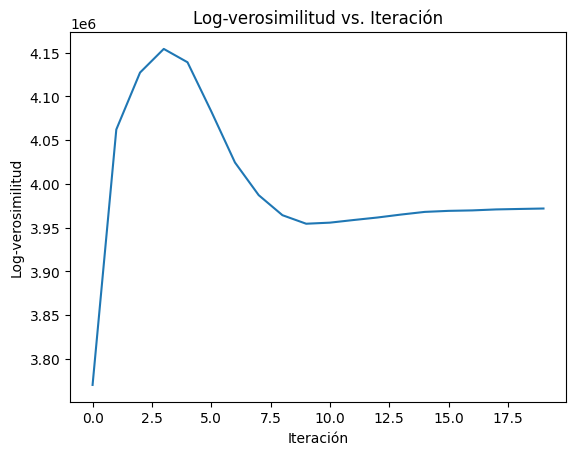

In [29]:
# Establecer la semilla global
np.random.seed(42)
random.seed(42)

# Ajustar modelo en 3000 valores del conjunto MNIST
n_components = 15
mfa = MixtureFA(n_components=n_components, n_latents=4, max_iter=20)
mfa.fit(X_train.T)

### Descripción de los resultados.

Ahora que hemos ajustado el modelo vamos a ver qué información podemos obtener de los parámetros calculados e intentar ver qué representan. En el proceso, resulta ilustrativo comparar estos resultados con los obtenidos en el ejercicio anterior en el que trabajamos con un único analizador.

En primer lugar, representamos las medias de cada una de las componentes.

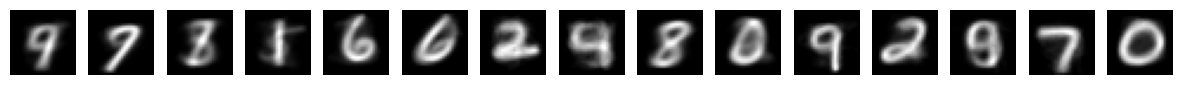

In [18]:
fig, axs = plt.subplots(1, n_components, figsize=(15, 4))
for i in range(n_components):
    axs[i].set_axis_off()
    axs[i].imshow(mfa.get_means()[i].reshape(28, 28), cmap='gray')


A continuación, los factores para cada una de las componentes.

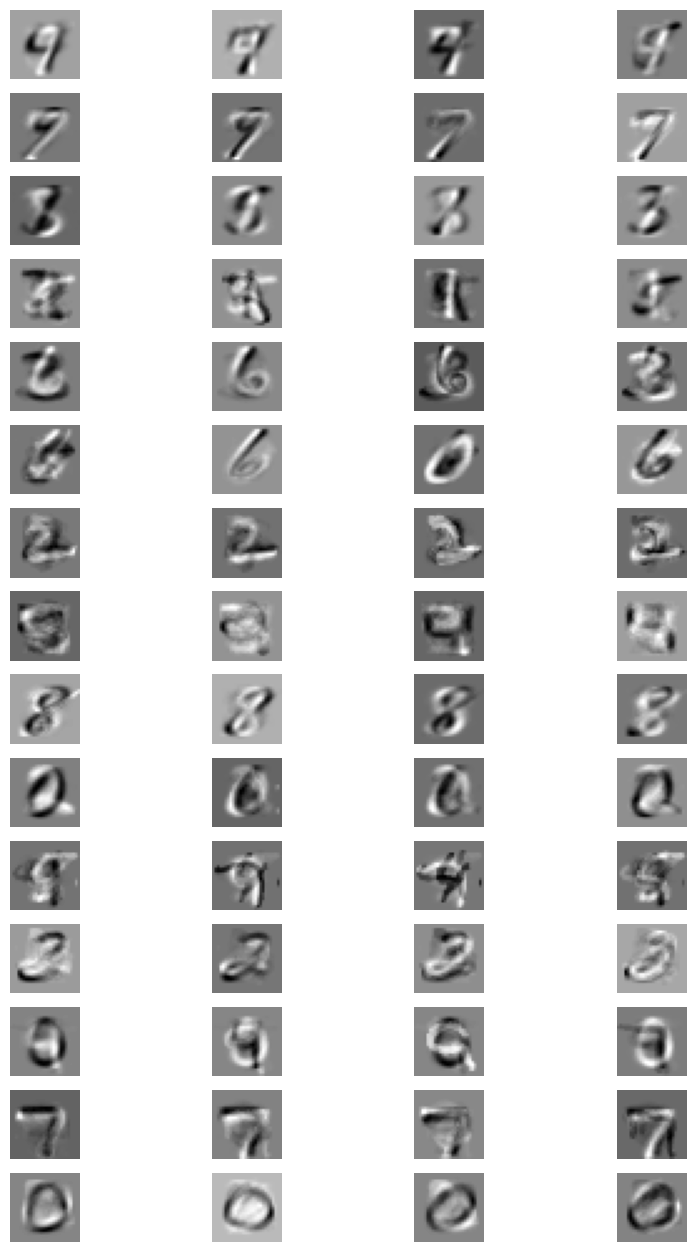

In [19]:
fig, axs = plt.subplots(n_components, 4, figsize=(10, 16))
for i in range(n_components):
    for j in range(4):
        axs[i, j].set_axis_off()
        axs[i, j].imshow(mfa.get_loadings()[i, :, j].reshape(28, 28), cmap='gray')


Por último, fijémonos en una componente (por ejemplo, la primera) y generemos algunas muestras. Esto es, tenemos que muestrear de la distribución normal multidimensional $\mathcal{N}(\boldsymbol{\mu}_0, \mathbf{W}_0\mathbf{W}_0^\mathrm{T} + \boldsymbol{\Psi})$.

In [20]:
rng = np.random.default_rng()

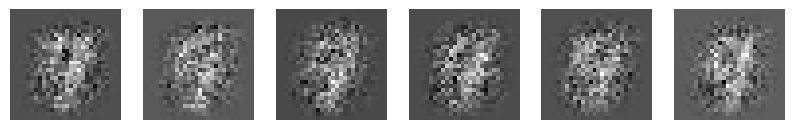

In [21]:
W = mfa.get_loadings()[0]  # Cargas del primer componente
mean = mfa.get_means()[0]  # Primer componente, de tamaño (784,)

# Matriz de covarianza
cov = W @ W.T + mfa.get_noise_covariance()

# Generación de muestras y visualización
digits = np.zeros((6, 784))
fig, axs = plt.subplots(1, 6, figsize=(10, 4))
for i in range(6):
    digits[i] = np.random.multivariate_normal(mean, cov)  # Media del primer componente
    axs[i].set_axis_off()
    axs[i].imshow(digits[i].reshape(28, 28), cmap='gray')


### Cuestiones
Comparar brevemente los resultados de este ejercicio con los del ejercicio anterior.

### Comparación entre la **Mezcla de Analizadores de Factores** y el **Ejercicio Preliminar**

#### 1. **Enfoque del Modelo**:
   - **Mezcla de Analizadores de Factores (MixtureFA)**:
     - Utiliza el algoritmo **EM (Expectation-Maximization)** para estimar una mezcla de modelos de factores latentes, considerando **múltiples clusters**.
     - El **paso E** calcula las responsabilidades y las expectativas de los factores latentes, y el **paso M** actualiza los parámetros del modelo.
   - **Ejercicio Preliminar (FA y PCA)**:
     - Se entrena un **analizador de factores** (FA) para obtener componentes latentes en el conjunto MNIST.
     - Utiliza una distribución probabilística para generar las componentes latentes, sin un enfoque de clustering como en la mezcla.

#### 2. **Propósito y Resultados**:
   - **Mezcla de Analizadores de Factores**:
     - Modela **diversidad en los datos** usando múltiples clusters, permitiendo una representación **más flexible** de los datos.
   - **Ejercicio Preliminar (FA y PCA)**:
     - FA captura la **estructura latente** subyacente, mientras que PCA se enfoca en reducir la dimensionalidad sin modelar explícitamente las relaciones latentes.

#### 3. **Comparación Técnica**:
   - **Enfoque Probabilístico vs. Lineal**:
     - **Mezcla de FA** es **probabilística** y ajusta parámetros para cada cluster en los pasos **E** y **M**.
     - **FA** y **PCA** son **deterministas**; FA busca factores latentes, mientras que PCA maximiza la varianza sin modelar explícitamente distribuciones.
   
   - **Actualización de Parámetros**:
     - En la **Mezcla de FA**, los parámetros se actualizan de forma iterativa en cada paso, lo que permite adaptarse a la estructura del modelo.
     - En el **Ejercicio Preliminar**, FA obtiene los parámetros sin la necesidad de pasos iterativos como en EM.

#### 4. **Conclusión**:
   - **Ventajas de la Mezcla de FA**: Ofrece una representación **más flexible** y precisa de los datos, permitiendo modelar **varios grupos** en los datos.
   - **Ventajas de FA y PCA**: FA es útil para un modelo generativo, mientras que PCA es más adecuado para **reducción de dimensionalidad**.
